In [1]:
import copy
import math
import itertools
import numpy as np
import scipy as sp
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

In [2]:
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf');

font = matplotlib.font_manager.FontProperties(fname='/System/Library/Fonts/Supplemental/Avenir.ttf')

## Simulating allele frequency dynamics

In [3]:
# here's the setup:
# diploid w/ one locus, four alleles: 0 (sensitive), 1, 2, 3 (resistant); 
# there are three environments, and fitnesses and dominance coefficients are different in different environments;
# we are assuming that the effects of mutation, recombination, and drift are negligible over the time scales considered;
# we further assume that resistant heterozygotes are codomimant (such that the fitness of e.g. 23 is the avg. of 22 and 33)

In [4]:
alleles = [0, 1, 2, 3] # sensitive and resistant alleles w/ one, two, and three mutations, respectively
genotypes = ['00', '01', '02', '03', '11', '12', '13', '22', '23', '33'] # allele combinations

# to parse out data:
alleles_dict = {0: 'IGFG', 1: 'VGFG', 2: 'VGFA', 3: 'VAYG'} # haplotype names to alleles notation mapping
genotypes_dict = dict(zip(genotypes, ['SS', 'SR1', 'SR2', 'SR3', 'R1R1', 'R1R2', 'R1R3', 'R2R2', 'R2R3', 'R3R3'])) # Marianna's notation

In [5]:
# ploting parameters:
grey = '#999999'  
allele_colors = {0: grey, 1: '#ffC300', 2: '#ff5733', 3: '#900c3f'} 
w = 2 # linewidth 
fontsize = 12 # font size
padsize = 12 # pad size
legendfontsize = 10 # legend font size

In [6]:
# getting the relative viabilities, always relative to 00
def get_w(s0, s1, s2, s3, h01, h02, h03):
    
    return {'00': 1, 
            '11': 1 + s1,
            '22': 1 + s2,
            '33': 1 + s3,
            '01': 1 + h01 * s1,
            '02': 1 + h02 * s2,
            '03': 1 + h03 * s3,
            '12': 1 + 0.5 * (s1 + s2),
            '13': 1 + 0.5 * (s1 + s3),
            '23': 1 + 0.5 * (s2 + s3)}

# getting h and s, always relative to 00
# note that we will replace all 0 viabilities w/ 0.01 
# so that we can use the chosen parametrization when we need to

def get_h_s(w_dict): # note that it does not matter whether w_dict contains relative or absolute viabilities
                     # since we'll normalize that out
        
    w_dict_non0 = {x: max(0.01, y) for x, y in w_dict.items()}
    
    s0 = 0
    s1 = w_dict_non0['11'] / w_dict_non0['00'] - 1
    s2 = w_dict_non0['22'] / w_dict_non0['00'] - 1
    s3 = w_dict_non0['33'] / w_dict_non0['00'] - 1
    
    hs = []
    for c, i in enumerate([s1, s2, s3]):
        if i == 0:
            hs.append(1/2) # it does not matter, could be anything
        else:
            hs.append((w_dict_non0['00'] - w_dict_non0['0' + str(c + 1)]) / (w_dict_non0['00'] - w_dict_non0[str(c + 1) + str(c + 1)]))
     
    return {'s0': s0,
            's1': s1,
            's2': s2,
            's3': s3,
            'h01': hs[0],
            'h02': hs[1],
            'h03': hs[2]}

In [7]:
# running the viability selection model as parametrized above
def simulate_allele_fs(fs_0, w, T, genotype_fs_0=None):
    
    """Runs simulations in the no-drug environment, 
       where any genotype with two resistant alleles carries a fitness cost s.
    
    args:    
        fs: initial allele frequencies
             type: a dictionary w/ alleles as keys and lists of frequencies as values
             e.g.: {0: [1], 1: [0], 2: [0], 3: [0]}
        w: relative or absolute viabilities,
            type: dict w/ genotypes as keys 
            e.g. w_dict in get_w
        T: number of generations
            type: int
            e.g.: 10
        
    returns: allele frequencies throughout time 
             type: a dictionary w/ alleles as keys and lists of frequencies as values
             e.g. {0: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 1: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   2: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 3: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
    """
    
    # if the initial genotype frequencies are not known, assume Hardy-Weinberg:
    if genotype_fs_0 == None:
        genotype_fs = {}
        for i in ['00', '01', '02', '03', '11', '12', '13', '22', '23', '33']:
            if len(set(i)) == 1:
                genotype_fs[i] = [fs_0[int(i[0])][0]**2]
            else:
                genotype_fs[i] = [2*fs_0[int(i[0])][0]*fs_0[int(i[1])][0]]
    else:
        genotype_fs = copy.deepcopy(genotype_fs_0)
            
    fs = copy.deepcopy(fs_0)
    
    for t in range(0, T - 1):
        
        denom = fs[0][t]**2*w['00'] + 2*fs[0][t]*fs[1][t]*w['01'] + 2*fs[0][t]*fs[2][t]*w['02'] + 2*fs[0][t]*fs[3][t]*w['03'] + \
                fs[1][t]**2*w['11'] + 2*fs[1][t]*fs[2][t]*w['12'] + 2*fs[1][t]*fs[3][t]*w['13'] + \
                fs[2][t]**2*w['22'] + 2*fs[2][t]*fs[3][t]*w['23'] + \
                fs[3][t]**2*w['33']

        nums = {0: fs[0][t]**2*w['00'] + fs[0][t]*fs[1][t]*w['01'] + fs[0][t]*fs[2][t]*w['02'] + fs[0][t]*fs[3][t]*w['03'],
                1: fs[0][t]*fs[1][t]*w['01'] + fs[1][t]**2*w['11'] + fs[1][t]*fs[2][t]*w['12'] + fs[1][t]*fs[3][t]*w['13'],
                2: fs[0][t]*fs[2][t]*w['02'] + fs[1][t]*fs[2][t]*w['12'] + fs[2][t]**2*w['22'] + fs[2][t]*fs[3][t]*w['23'],
                3: fs[0][t]*fs[3][t]*w['03'] + fs[1][t]*fs[3][t]*w['13'] + fs[2][t]*fs[3][t]*w['23'] + fs[3][t]**2*w['33']}
        
        for i in alleles:
            fs[i].append(nums[i] / denom)
             
        genotype_fs['00'].append(fs[0][t]**2*w['00'] / denom)
        genotype_fs['01'].append(2*fs[0][t]*fs[1][t]*w['01'] / denom)
        genotype_fs['02'].append(2*fs[0][t]*fs[2][t]*w['02'] / denom)
        genotype_fs['03'].append(2*fs[0][t]*fs[3][t]*w['03'] / denom)
        genotype_fs['11'].append(fs[1][t]**2*w['11'] / denom)
        genotype_fs['12'].append(2*fs[1][t]*fs[2][t]*w['12'] / denom)
        genotype_fs['13'].append(2*fs[1][t]*fs[3][t]*w['13'] / denom)
        genotype_fs['22'].append(fs[2][t]**2*w['22'] / denom)
        genotype_fs['23'].append(2*fs[2][t]*fs[3][t]*w['23'] / denom)
        genotype_fs['33'].append(fs[3][t]**2*w['33'] / denom)
    
    return fs, genotype_fs

#### Downloading experimental data

In [8]:
# retreiving appropriate parameter values:
# need to know initial frequencies, selection/dominance coefficients, Ts

# data privided by Marianna
allele_freqs = pd.read_csv('./data/haplotype_freqs.csv') 

dates = sorted(list(set(allele_freqs['Date'])))

# data privided by Marianna
date_generation_dose = pd.read_csv('./data/date_generation_treatment.csv') 

date_generation_dose_dict = {}
for i in dates:
    for j in range(len(date_generation_dose)):
        if date_generation_dose['Date'][j] == i:
            date_generation_dose_dict[i] = [date_generation_dose['generation'][j] - 1, date_generation_dose['dose_ppm'][j]]

# adding the last timepoint:
date_generation_dose_dict[dates[-1]] = [10, 0.0]

# w/ pesticide
allele_freqs_dates = allele_freqs[(allele_freqs['Date'].isin(dates)) & (allele_freqs['treatment'] == 'P')]
allele_freqs_dates.loc[:, 'cage'] = allele_freqs_dates['cage'].apply(lambda x: int(x[1:]))
avg_allele_freqs = {}
for i in alleles:
    avg_allele_freqs[i] = []
    for j in dates: 
        freqs = allele_freqs_dates[(allele_freqs_dates['haplotype_class'] == alleles_dict[i]) & (allele_freqs_dates['Date'] == j)]['frequency']
        avg_allele_freqs[i].append([date_generation_dose_dict[j][0], np.median(freqs), np.std(freqs)])
        
# no pesticide
allele_freqs_control_dates = allele_freqs[(allele_freqs['Date'].isin(dates)) & (allele_freqs['treatment'] == 'E')]
allele_freqs_control_dates.loc[:, 'cage'] = allele_freqs_control_dates['cage'].apply(lambda x: int(x[1:]))
avg_allele_freqs_control = {}
allele_trj_control = []
for i in alleles:
    avg_allele_freqs_control[i] = []
    for j in dates: 
        freqs = allele_freqs_control_dates[(allele_freqs_control_dates['haplotype_class'] == alleles_dict[i]) & (allele_freqs_control_dates['Date'] == j)]['frequency']
        avg_allele_freqs_control[i].append([date_generation_dose_dict[j][0], np.median(freqs), np.std(freqs)])
        

In [9]:
# reading lab viability measurements:

viabilities = {}
conc = [0.0, 2.5, 5.0, 7.5, 10.0, 15.0]

# reading viability data, which was generated by
# write.csv(data.viability, "no_pesticide_viability.csv", row.names=FALSE) in Viability_FINAL.Rmd that Marianna shared
no_pesticide_viability = pd.read_csv('./data/no_pesticide_viability.csv') 

viabilities[0.0] = {}
for i in genotypes:
    if i not in ['12', '13', '23']:
        viabilities[0.0][i] = np.mean(no_pesticide_viability[no_pesticide_viability['Genotype'].isin([genotypes_dict[i]])]['Survival']) / 100
    else: # assuming codominance
        viabilities[0.0][i] = (0.5 * np.mean(no_pesticide_viability[no_pesticide_viability['Genotype'].isin([genotypes_dict[i[0] + i[0]]])]['Survival']) +
                               0.5 * np.mean(no_pesticide_viability[no_pesticide_viability['Genotype'].isin([genotypes_dict[i[1] + i[1]]])]['Survival'])) / 100
        
# reading viability data, which was generated by
# write.csv(resistance.data, "pesticide_viability.csv", row.names=FALSE) in Resistance_MK_Updated_NEW.Rmd that Marianna shared
pesticide_viability = pd.read_csv('./data/pesticide_viability.csv') 
pesticide_viability.insert(6, "Survival", [pesticide_viability['Alive'][i] / pesticide_viability['Total'][i] for i in range(len(pesticide_viability))], True)

for c in conc[1:]:
    viabilities[c] = {}
    for i in genotypes:
        if i not in ['12', '13', '23']:
            viabilities[c][i] = np.mean(pesticide_viability[(pesticide_viability['Dose_.ppm.'] == c) & (pesticide_viability['Genotype'].isin([genotypes_dict[i]]))]['Survival'])
        else: # assuming codominance
            viabilities[c][i] = (0.5 * np.mean(pesticide_viability[(pesticide_viability['Dose_.ppm.'] == c) & (pesticide_viability['Genotype'].isin([genotypes_dict[i[0] + i[0]]]))]['Survival']) +
                                 0.5 * np.mean(pesticide_viability[(pesticide_viability['Dose_.ppm.'] == c) & (pesticide_viability['Genotype'].isin([genotypes_dict[i[1] + i[1]]]))]['Survival']))
    

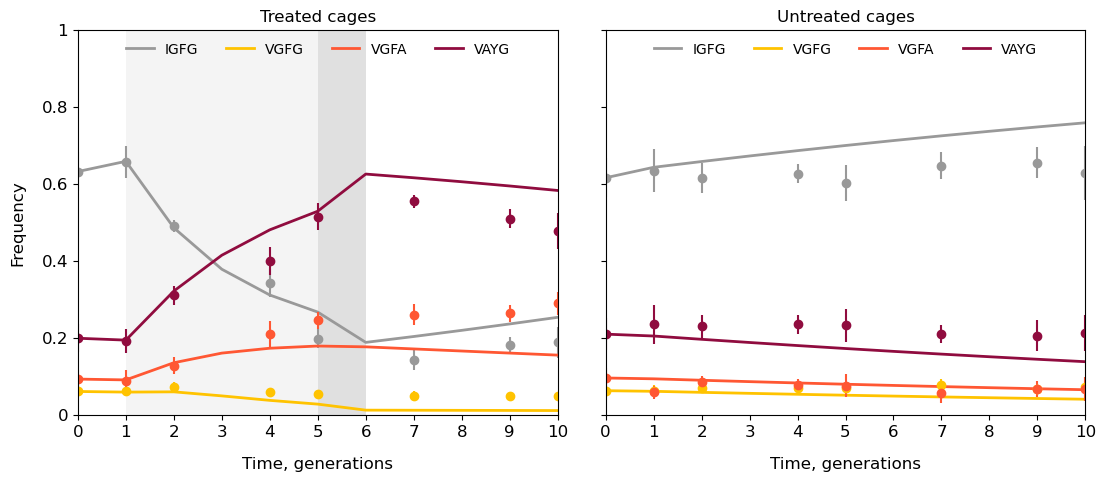

In [10]:
# running simulations & plotting the results: 
fig = plt.figure(figsize=(13, 5))

grid = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[1, 1], wspace=0.1,
                         height_ratios=[1], hspace=0)

# how many generations in each environment (+1 generation for the initial timepoint)
t1 = 1 + 1
t2 = 4 + 1
t3 = 1 + 1
t4 = 4 + 1
t = t1 + t2 + t3 + t4 - 4

for c in range(2):
    
    plt.subplot(grid[c // 2, c % 2])
    
    if c == 0: # left panel
    
        plt.axvspan(t1 - 1, t1 - 1 + t2 - 1, facecolor=grey, alpha=0.1)
        plt.axvspan(t1 - 1 + t2 - 1, t1 - 1 + t2 - 1 + t3 - 1, facecolor=grey, alpha=0.3)
        
        # simulating the experiment:
        fs_1, gen_fs_1 = simulate_allele_fs({x: [avg_allele_freqs[x][0][1]] for x in alleles}, viabilities[0.0], t1)
        fs_2, gen_fs_2 = simulate_allele_fs({x: [fs_1[x][-1]] for x in alleles}, viabilities[2.5], t2, {x: [gen_fs_1[x][-1]] for x in genotypes})
        fs_3, gen_fs_3 = simulate_allele_fs({x: [fs_2[x][-1]] for x in alleles}, viabilities[7.5], t3, {x: [gen_fs_2[x][-1]] for x in genotypes})
        fs_4, gen_fs_4 = simulate_allele_fs({x: [fs_3[x][-1]] for x in alleles}, viabilities[0.0], t4 + 1, {x: [gen_fs_3[x][-1]] for x in genotypes})

        # merging all frequencies:
        fs = {x: fs_1[x] + fs_2[x][1:] + fs_3[x][1:] + fs_4[x][1:] for x in alleles}
        gen_fs = {x: gen_fs_1[x] + gen_fs_2[x][1:] + gen_fs_3[x][1:] + gen_fs_4[x][1:] for x in genotypes}

        # checking that genotype frequencies give the right allele frequencies:
        for i in range(t):
            for j in alleles:
                f = sum([0.5 * gen_fs[x][i] for x in genotypes if len(set(x)) == 2 and str(j) in x]) + gen_fs[str(j) + str(j)][i]
                if (fs[j][i] - f) / fs[j][i] > 0.01: # if the error is more than 0.01
                    if i > 0: # the first generations should be off since we have assumed Hardy-Weinberg
                        print(i)
        
        # saving the output - uncomment this part if needed
        sim_allele_freqs_pest = pd.DataFrame(columns=['allele', 't=0', 't=1', 't=2', 't=3', 't=4', 't=5', 't=6', 't=7', 't=8', 't=9', 't=10'])
        for i in alleles:
            sim_allele_freqs_pest.loc[len(sim_allele_freqs_pest.index)] = [alleles_dict[i]] + fs[i][:-1]
            sim_allele_freqs_pest.to_csv('./data/sim_allele_freqs_pesticide.csv', index=False) 

        for i in alleles:
            plt.plot(range(0, t + 2), fs[i], color=allele_colors[i], label=alleles_dict[i], linewidth=w)
            plt.errorbar(x=[x[0] for x in avg_allele_freqs[i]], y=[x[1] for x in avg_allele_freqs[i]], yerr=[x[2] for x in avg_allele_freqs[i]], fmt='o', color=allele_colors[i])
    
        plt.title('Treated cages', fontsize=fontsize)
        
    elif c == 1: # right panel
        # now, simulating the experiment with no pesticide:
        fs_control, gen_fs_control = simulate_allele_fs({x: [avg_allele_freqs_control[x][0][1]] for x in alleles}, viabilities[0.0], t + 2)

        # checking that genotype frequencies give the right allele frequencies:
        for i in range(t):
            for j in alleles:
                f = sum([0.5 * gen_fs[x][i] for x in genotypes if len(set(x)) == 2 and str(j) in x]) + gen_fs[str(j) + str(j)][i]
                if (fs[j][i] - f) / fs[j][i] > 0.01: # if the error is more than 0.01
                    if i > 0: # the first generations should be off since we have assumed Hardy-Weinberg
                        print(i)

        # saving the output - uncomment if needed
        sim_allele_freqs_control = pd.DataFrame(columns=['allele', 't=0', 't=1', 't=2', 't=3', 't=4', 't=5', 't=6', 't=7', 't=8', 't=9', 't=10'])
        for i in alleles:
            sim_allele_freqs_control.loc[len(sim_allele_freqs_control.index)] = [alleles_dict[i]] + fs_control[i][:-1]
            sim_allele_freqs_control.to_csv('./data/sim_allele_freqs_control.csv', index=False) 
            
        for i in alleles:
            plt.plot(range(t + 2), fs_control[i], color=allele_colors[i], label=alleles_dict[i], linewidth=w)
            plt.errorbar(x=[x[0] for x in avg_allele_freqs_control[i]], y=[x[1] for x in avg_allele_freqs_control[i]], yerr=[x[2] for x in avg_allele_freqs_control[i]], fmt='o', color=allele_colors[i])
    
        plt.title('Untreated cages', fontsize=fontsize)
    
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    plt.tick_params(axis='both', labelsize=fontsize)

    plt.ylim(0, 1)
    plt.xlim(0, 10)
    
    if c == 0:
        plt.ylabel('Frequency', fontsize=fontsize, labelpad=padsize);
        plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    else:
        plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], [])
    plt.xlabel('Time, generations', fontsize=fontsize, labelpad=padsize);  
    
    plt.legend(frameon=False, fontsize=legendfontsize, loc='upper center', handletextpad=0.8, ncol=4);

plt.savefig('./figs/simulated_allele_freqs.pdf', dpi=600, bbox_inches='tight') 

In [11]:
# let's now estimate h and s from viability measurements using the definitions above:
# can check that if we use these values, we'll get the viabilities back - done! at 7.5 ppm, cannot find h01 since s1 = s0
h_s_dict = {0.0: get_h_s(viabilities[0.0]),
            2.5: get_h_s(viabilities[2.5]),
            7.5: get_h_s(viabilities[7.5])} # we had to assume that not all sensitive flies die at this conc, so the numbers might be off

In [12]:
h_s_dict[0]

{'s0': 0,
 's1': -0.145413870246085,
 's2': -0.17225950782997768,
 's3': -0.1319910514541388,
 'h01': 0.29230769230769255,
 'h02': 0.16883116883116894,
 'h03': 0.3220338983050847}

## Simulating population resistance 

In [13]:
# calculating resistance in the population as a weighted sum
def calculate_resistance_in_pop(gen_fs, gen_rs): # takes two dictionaries with genotypes as keys
    resistance = 0 
    for i in genotypes:
        resistance += gen_rs[i] * gen_fs[i]
    return resistance

In [14]:
# reading resistance data provided by Marianna
resistance_data = pd.read_csv('./data/resistance_cage.csv') # so that the dates match across files
resistance_data = resistance_data.replace('2021-08-25', '2021-08-24')

resistance_t_pesticide = {}
for j in date_generation_dose_dict.keys():
    resistance_t_pesticide[j] = []
    for k in conc:
        resistance_t_pesticide[j].append([np.median([resistance_data['mean_Survival'][i] for i in range(len(resistance_data)) 
                                          if resistance_data['Treatment'][i] == 'P' and 
                                          resistance_data['Date'][i] == j and 
                                          resistance_data['Dose_ppm'][i] == k]),
                                          np.std([resistance_data['mean_Survival'][i] for i in range(len(resistance_data)) 
                                          if resistance_data['Treatment'][i] == 'P' and 
                                          resistance_data['Date'][i] == j and 
                                          resistance_data['Dose_ppm'][i] == k])])

resistance_t_control = {}
for j in date_generation_dose_dict.keys():
    resistance_t_control[j] = []
    for k in conc:
        resistance_t_control[j].append([np.median([resistance_data['mean_Survival'][i] for i in range(len(resistance_data)) 
                                        if resistance_data['Treatment'][i] == 'E' and 
                                        resistance_data['Date'][i] == j and 
                                        resistance_data['Dose_ppm'][i] == k]),
                                        np.std([resistance_data['mean_Survival'][i] for i in range(len(resistance_data)) 
                                        if resistance_data['Treatment'][i] == 'E' and 
                                        resistance_data['Date'][i] == j and 
                                        resistance_data['Dose_ppm'][i] == k])])


/Users/alyulina/Software/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/alyulina/Software/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/alyulina/Software/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/alyulina/Software/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/alyulina/Software/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/Users/alyulina/Software/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/alyulina/Software/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/Users/alyulina/Software/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/alyulina/Software/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/Users/alyulina/Software/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/alyulina/Software/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN ax

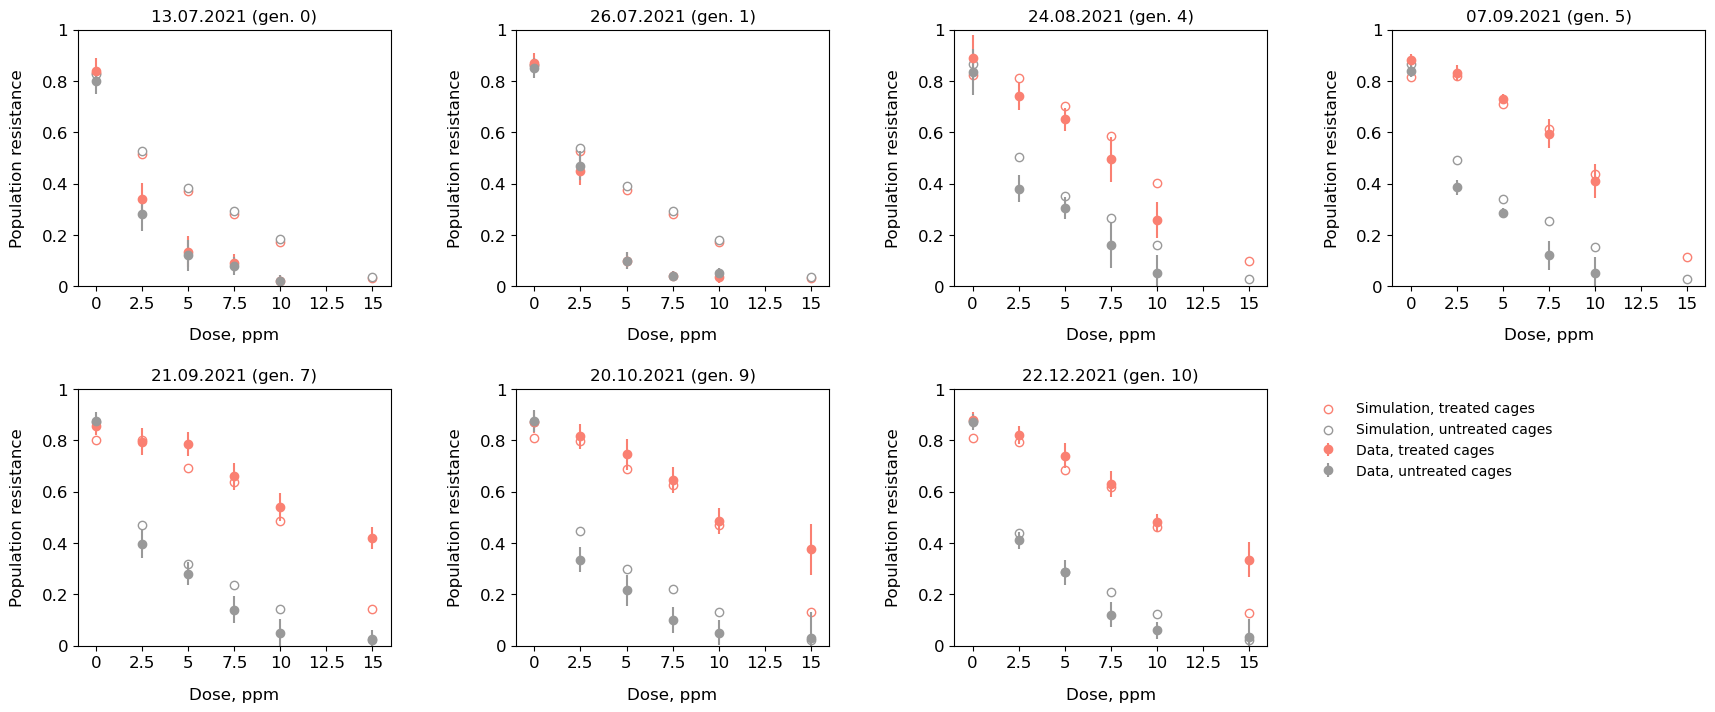

In [15]:
# saving simulated pop. resistances
sim_resistance_data = pd.DataFrame(columns=['resistance', 'environment', 'drug conc.', 'date', 'gen.'])

fig = plt.figure(figsize=(21, 8))

grid = gridspec.GridSpec(ncols=4, nrows=2,
                         width_ratios=[1, 1, 1, 1], wspace=0.4,
                         height_ratios=[1, 1], hspace=0.4)

dates_to_plot = ['2021-07-13', '2021-07-26', '2021-08-24', '2021-09-07', '2021-09-21', '2021-10-20', '2021-12-22']
# ignoring the first one (since we had to assume Hardy-Weinberg), 
# the last one since we are unsure about generations, 
# and the middle ones for which the dates do not match

for i, date in enumerate(dates_to_plot):
    plt.subplot(grid[i // 4, i % 4])        
    
    g = int(date_generation_dose_dict[date][0])
    gen_fs_g = {x: gen_fs[x][g] for x in genotypes}
    gen_fs_g_control = {x: gen_fs_control[x][g] for x in genotypes}
        
    for j, dose in enumerate(conc):
        
        plt.scatter(dose, calculate_resistance_in_pop(gen_fs_g, viabilities[dose]), marker='o', facecolor='white', edgecolor='salmon')
        plt.scatter(dose, calculate_resistance_in_pop(gen_fs_g_control, viabilities[dose]), marker='o', facecolor='white', edgecolor=grey)
    
        plt.errorbar(x=dose, y=resistance_t_pesticide[date][j][0] / 100, yerr=resistance_t_pesticide[date][j][1] / 100, fmt='o', color='salmon')
        plt.errorbar(x=dose, y=resistance_t_control[date][j][0] / 100, yerr=resistance_t_pesticide[date][j][1] / 100, fmt='o', color=grey)
        
        sim_resistance_data.loc[len(sim_resistance_data.index)] = [calculate_resistance_in_pop(gen_fs_g, viabilities[dose]), 'pesticide', dose, date, int(date_generation_dose_dict[date][0])]  
        sim_resistance_data.loc[len(sim_resistance_data.index)] = [calculate_resistance_in_pop(gen_fs_g_control, viabilities[dose]), 'control', dose, date, int(date_generation_dose_dict[date][0])]  
    
    if i == 6: # this is just for the legend
        plt.errorbar(x=-1, y=-1, yerr=0.5, fmt='o', color='salmon', label='Data, treated cages')
        plt.scatter(-1, -1, marker='o', facecolor='white', edgecolor='salmon', label='Simulation, treated cages')

        plt.errorbar(x=-1, y=-1, yerr=0.5, fmt='o', color=grey, label='Data, untreated cages')
        plt.scatter(-1, -1, marker='o', facecolor='white', edgecolor=grey, label='Simulation, untreated cages')

        plt.legend(frameon=False, fontsize=legendfontsize, loc='upper right', bbox_to_anchor=(1.95, 1.0, 0.0, 0.0), handletextpad=1);
    
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.xticks([0, 2.5, 5, 7.5, 10, 12.5, 15], [0, 2.5, 5, 7.5, 10, 12.5, 15])
    
    plt.tick_params(axis='both', labelsize=fontsize)
    
    plt.ylim(0, 1)
    plt.xlim(-1, 16)
    
    plt.ylabel('Population resistance', fontsize=fontsize, labelpad=padsize);
    plt.xlabel('Dose, ppm', fontsize=fontsize, labelpad=padsize); 
    
    plt.title(date[-2:] + '.' + date[-5:-3] + '.' + date[:4] + ' (gen. ' + "{:.0f}".format(date_generation_dose_dict[date][0]) + ')', fontsize=fontsize)
    
sim_resistance_data.to_csv('./data/sim_resistance_data.csv', index=False) 
plt.savefig('./figs/simulated_resistances.pdf', dpi=600, bbox_inches='tight') 

## Inferring ranges of possible parameter values

In [16]:
# now let's assume that h is always constant, and that is it bounded by 0 and 1;
# without using the lab measurements (we can't possibly measure cost in the lab well), what kinds of s would fit the data,
# both the very stable trajectories at low frequencies and the decline at high frequencies?

In [17]:
np.random.seed(42)

In [18]:
B = 10000 # number of bootstrap replicates

# control cages first
ts_control = np.array([0, 1, 2, 4, 5, 7, 9, 10])
trajectories_control = []
for rep in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    df = allele_freqs_control_dates[(allele_freqs_control_dates['cage'] == rep) & (allele_freqs_control_dates['haplotype_class'] != alleles_dict[0])].groupby(['Date'], as_index=False).sum()
    trajectory = {}
    for t in ts_control:
        try:
            f = df[df['Date'].apply(lambda x: date_generation_dose_dict[x][0]) == t]['frequency'].iloc[0]
            trajectory[t] = f
        except (KeyError, IndexError):
             pass       
    trajectories_control.append(trajectory)

bootstrapped_slope_intercept_control = []
for b in range(B):
    sampled_ids = np.random.choice(np.arange(len(trajectories_control)), len(trajectories_control), replace=True)
    sampled_trajectories = np.array(trajectories_control)[sampled_ids]
    
    avg_trajectory = [np.mean([x[t] for x in sampled_trajectories if t in x]) for t in ts_control]
    model_control = LinearRegression().fit(ts_control.reshape((len(ts_control), 1)), avg_trajectory)
    bootstrapped_slope_intercept_control.append([model_control.coef_[0], model_control.intercept_])

# mean, confidence intervals
mean_slope_control = {}
for c in [0.85, 0.9, 0.95]: # confidence levels
    lower_percentile = (1.0 - c) / 2.0 * 100
    upper_percentile = (1.0 + c) / 2.0 * 100
    
    mean_slope_control[c] = [np.mean([x[0] for x in bootstrapped_slope_intercept_control]), 
                             np.percentile([x[0] for x in bootstrapped_slope_intercept_control], lower_percentile),
                             np.percentile([x[0] for x in bootstrapped_slope_intercept_control], upper_percentile)] 

In [19]:
# now for pesticide (only the no pesticide part)
ts = np.array([7, 9, 10])
trajectories = []
for rep in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    df = allele_freqs_dates[(allele_freqs_dates['cage'] == rep) & (allele_freqs_dates['haplotype_class'] != alleles_dict[0])].groupby(['Date'], as_index=False).sum()
    trajectory = {}
    for t in ts:
        try:
            f = df[df['Date'].apply(lambda x: date_generation_dose_dict[x][0]) == t]['frequency'].iloc[0]
            trajectory[t] = f
        except (KeyError, IndexError):
             pass       
    trajectories.append(trajectory)

bootstrapped_slope_intercept = []
for b in range(B):
    sampled_ids = np.random.choice(np.arange(len(trajectories)), len(trajectories), replace=True)
    sampled_trajectories = np.array(trajectories)[sampled_ids]
    
    avg_trajectory = [np.mean([x[t] for x in sampled_trajectories if t in x]) for t in ts]
    model = LinearRegression().fit(ts.reshape((len(ts), 1)), avg_trajectory)
    bootstrapped_slope_intercept.append([model.coef_[0], model.intercept_])

# mean, confidence intervals
mean_slope = {}
cis = [0.85, 0.9, 0.95]
for c in cis: # confidence levels
    lower_percentile = (1.0 - c) / 2.0 * 100
    upper_percentile = (1.0 + c) / 2.0 * 100
    
    mean_slope[c] = [np.mean([x[0] for x in bootstrapped_slope_intercept]), 
                     np.percentile([x[0] for x in bootstrapped_slope_intercept], lower_percentile),
                     np.percentile([x[0] for x in bootstrapped_slope_intercept], upper_percentile)] 

In [20]:
# inferring s from the slope and initial frequency given h
def s(slope, f0, h): # from 1.27 in Ewens
    return slope / (f0 * (1 - f0) * (f0 + h * (1 - 2 * f0)))

max h = 0.27, min. s = -0.046, max. s = -0.025


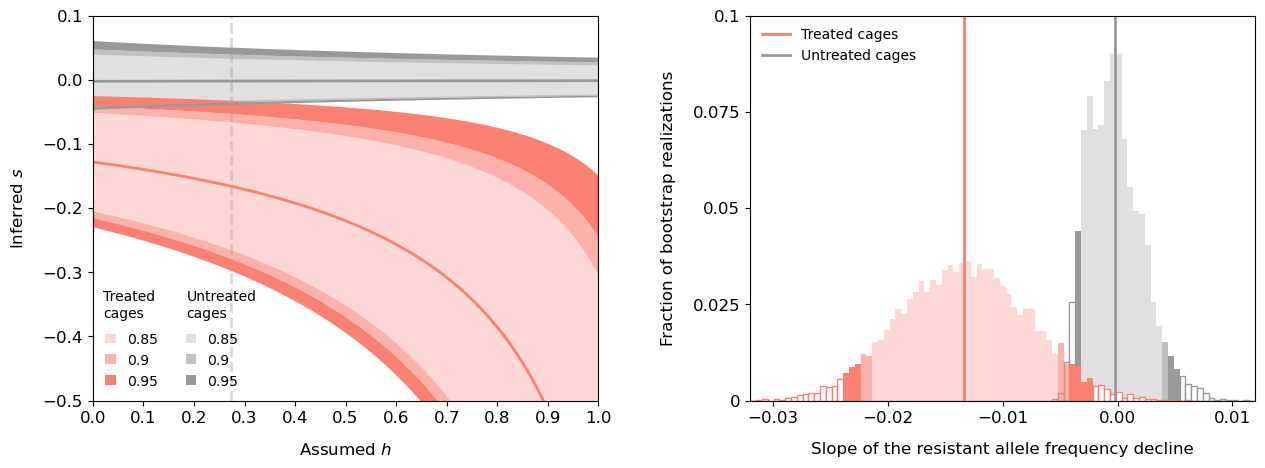

In [21]:
fig = plt.figure(figsize=(15, 5))

grid = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[1, 1], wspace=0.3,
                         height_ratios=[1], hspace=0)

f0_control = np.mean([x[0] for x in trajectories_control if 0 in x])
f0 = np.mean([x[7] for x in trajectories if 7 in x])  
xs = np.linspace(0, 1, 100) 

# saving the output - uncomment if needed
inferred_s = pd.DataFrame(columns=['h', '0.85', '0.9', '0.95'], index=range(len(xs)))
for i, h in enumerate(xs):
    inferred_s.loc[i] = [h, (s(mean_slope[0.85][1], f0, h), s(mean_slope[0.85][2], f0, h)),
                         (s(mean_slope[0.9][1], f0, h), s(mean_slope[0.9][2], f0, h)),
                         (s(mean_slope[0.95][1], f0, h), s(mean_slope[0.95][2], f0, h))] 
inferred_s.to_csv('./data/inferred_s.csv', index=False) 

inferred_s_control = pd.DataFrame(columns=['h', '0.85', '0.9', '0.95'], index=range(len(xs)))
for i, h in enumerate(xs):
    inferred_s_control.loc[i] = [h, (s(mean_slope_control[0.85][1], f0_control, h), s(mean_slope_control[0.85][2], f0_control, h)),
                                 (s(mean_slope_control[0.9][1], f0_control, h), s(mean_slope_control[0.9][2], f0_control, h)),
                                 (s(mean_slope_control[0.95][1], f0_control, h), s(mean_slope_control[0.95][2], f0_control, h))]
inferred_s_control.to_csv('./data/inferred_s_control.csv', index=False) 
    

for d in range(2):
    
    plt.subplot(grid[d // 2, d % 2])
    
    if d == 0: # left panel 

        # filling in the space between two lowest confidence intervals:
        plt.fill_between(xs, [s(mean_slope_control[cis[0]][1], f0_control, h) for h in xs], 
                             [s(mean_slope_control[cis[0]][2], f0_control, h) for h in xs], 
                             color=grey, alpha=0.3, linewidth=0, label=str(cis[0]))

        plt.fill_between(xs, [s(mean_slope[cis[0]][1], f0, h) for h in xs], 
                             [s(mean_slope[cis[0]][2], f0, h) for h in xs], 
                             color='salmon', alpha=0.3, linewidth=0, label=str(cis[0]))
        
        # plotting the means:
        plt.plot(xs, [s(mean_slope_control[cis[0]][0], f0_control, h) for h in xs], color=grey, linewidth=2, alpha=1, zorder=2)
        plt.plot(xs, [s(mean_slope[cis[0]][0], f0, h) for h in xs], color='salmon', linewidth=2, alpha=1, zorder=2)

        # finding where contour lines overlap:
        h_critical = xs[np.argmin(np.abs([np.array([s(mean_slope_control[cis[0]][1], f0_control, h) for h in xs]) - np.array([s(mean_slope[c][2], f0, h) for h in xs])]))]
        plt.axvline(h_critical, color='#d9d9d9', linewidth=2, linestyle='--', zorder=-2, alpha=1)
        print('max h = ' + str(round(h_critical, 2)) + ', min. s = ' + str(round(s(mean_slope_control[c][1], f0_control, 0), 3)) + ', max. s = ' + str(round(s(mean_slope[c][2], f0, 0), 3)))
    
        # coloring the rest of the space:
        for i in range(1, 3):
            plt.fill_between(xs, [s(mean_slope[cis[i]][1], f0, h) for h in xs], 
                                 [s(mean_slope[cis[i - 1]][1], f0, h) for h in xs], 
                                 color='salmon', alpha=min(i * 0.6, 1), linewidth=0, label=str(cis[i]))
        
            plt.fill_between(xs, [s(mean_slope[cis[i]][2], f0, h) for h in xs], 
                                 [s(mean_slope[cis[i - 1]][2], f0, h) for h in xs], 
                                 color='salmon', alpha=min(i * 0.6, 1), linewidth=0)
        
            plt.fill_between(xs, [s(mean_slope_control[cis[i]][1], f0_control, h) for h in xs], 
                                 [s(mean_slope_control[cis[i - 1]][1], f0_control, h) for h in xs], 
                                 color=grey, alpha=min(i * 0.6, 1), linewidth=0, label=str(cis[i]))
        
            plt.fill_between(xs, [s(mean_slope_control[cis[i]][2], f0_control, h) for h in xs], 
                                 [s(mean_slope_control[cis[i - 1]][2], f0_control, h) for h in xs], 
                                 color=grey, alpha=min(i * 0.6, 1), linewidth=0)

        plt.xlim(0, 1)    
        plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

        plt.ylim(-0.5, 0.1)
        plt.yticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1])

        plt.tick_params(axis='both', labelsize=fontsize)

        handles, labels = plt.gca().get_legend_handles_labels()
        order = [1, 2, 4, 0, 3, 5]
        plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], 
                   frameon=False, fontsize=legendfontsize, ncol=2, loc='lower left', handlelength=0.75);

        plt.text(0.02, -0.37, 'Treated\ncages', fontsize=legendfontsize)
        plt.text(0.185, -0.37, 'Untreated\ncages', fontsize=legendfontsize)
    
        plt.xlabel('Assumed $h$', fontsize=fontsize, labelpad=padsize);
        plt.ylabel('Inferred $s$', fontsize=fontsize, labelpad=padsize);
        
    elif d == 1: # right panel
        
        counts, values, bars = plt.hist([x[0] for x in bootstrapped_slope_intercept_control], bins=np.linspace(-0.035, 0.015, 100), color=grey, alpha=0.3)
        for j, (count, value, bar) in enumerate(zip(counts, values, bars)):
            if (value >= mean_slope_control[cis[2]][1] and value <= mean_slope_control[cis[1]][1]) or (value >= mean_slope_control[cis[1]][2] and value <= mean_slope_control[cis[2]][2]):
                bar.set_alpha(1)
            elif (value >= mean_slope_control[cis[1]][1] and value <= mean_slope_control[cis[0]][1]) or (value >= mean_slope_control[cis[0]][2] and value <= mean_slope_control[cis[1]][2]):
                bar.set_alpha(0.6)
            elif value <= mean_slope_control[cis[2]][1] or value >= mean_slope_control[cis[2]][2]:
                bar.set_alpha(1)
                bar.set_color('#ffffff')
                bar.set_edgecolor(grey)
        
        counts, values, bars = plt.hist([x[0] for x in bootstrapped_slope_intercept], bins=np.linspace(-0.035, 0.015, 100), color='salmon', alpha=0.3)
        for j, (count, value, bar) in enumerate(zip(counts, values, bars)):
            if (value >= mean_slope[cis[2]][1] and value <= mean_slope[cis[1]][1]) or (value >= mean_slope[cis[1]][2] and value <= mean_slope[cis[2]][2]):
                bar.set_alpha(1)
            elif (value >= mean_slope[cis[1]][1] and value <= mean_slope[cis[0]][1]) or (value >= mean_slope[cis[0]][2] and value <= mean_slope[cis[1]][2]):
                bar.set_alpha(0.6)
            elif value <= mean_slope[cis[2]][1] or value >= mean_slope[cis[2]][2]:
                bar.set_alpha(1)
                bar.set_color('#ffffff')
                bar.set_edgecolor('salmon')
                    
        plt.axvline(np.mean([x[0] for x in bootstrapped_slope_intercept]), color='salmon', linewidth=2, label='Treated cages')
        plt.axvline(np.mean([x[0] for x in bootstrapped_slope_intercept_control]), color=grey, linewidth=2, label='Untreated cages')

        plt.legend(frameon=False, fontsize=legendfontsize)

        plt.xlim(-0.032, 0.012)
        plt.ylim(0, 1000)
        plt.yticks([0, 250, 500, 750, 1000], [0, 250 / B, 500 / B, 750 / B, 1000 / B])
        plt.xticks([-0.03, -0.02, -0.01, 0, 0.01])

        plt.tick_params(axis='both', labelsize=fontsize)

        plt.xlabel('Slope of the resistant allele frequency decline', fontsize=fontsize, labelpad=padsize);
        plt.ylabel('Fraction of bootstrap realizations', fontsize=fontsize, labelpad=padsize);

plt.savefig('./figs/inferred_s_h_mean_and_cis.pdf', dpi=600, bbox_inches='tight') 

## Simulating the dynamics of recessive and codominant alleles

In [22]:
def f_t(s, h, f0, T):
    freqs = [f0]
    f = f0
    for t in range(1, T):
        f1 = (f**2*(1+s) + f*(1-f)*(1+h*s)) / (f**2*(1+s) + 2*f*(1-f)*(1+h*s) + (1-f)**2)
        freqs.append(f1)
        f = f1
    return freqs

Assuming s = -0.3, h = 0.1, it would take 964 gen. to reach 1% freq. starting from f = 0.86
Assuming s = -0.3, h = 0.1, it would take 832 gen. to reach 1% freq. starting from f = 0.37
Assuming s = -0.3, h = 0.2, it would take 663 gen. to reach 1% freq. starting from f = 0.86
Assuming s = -0.3, h = 0.2, it would take 527 gen. to reach 1% freq. starting from f = 0.37
Assuming s = -0.3, h = 0.3, it would take 535 gen. to reach 1% freq. starting from f = 0.86
Assuming s = -0.3, h = 0.3, it would take 395 gen. to reach 1% freq. starting from f = 0.37


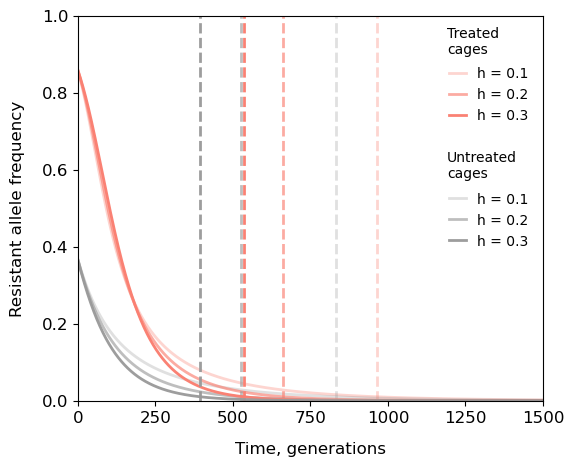

In [23]:
plt.figure(figsize=(6, 5))

# saving the output - uncomment if needed
f_t_h = pd.DataFrame(columns=['f0', 'h, assuming s = -0.3'] + ['t = ' + str(i) for i in range(10001)], index=range(6))
c = 0
for j, freq in enumerate([f0, f0_control]):
    for i, h in enumerate([0.1, 0.2, 0.3]):
        f_t_h.loc[c] = [freq, h] + f_t(-0.03, h, freq, 10001)
        c += 1
f_t_h.to_csv('./data/freq_dynamics_h.csv', index=False) 
    

for i, h in enumerate([0.1, 0.2, 0.3]):
    plt.plot(range(10001), f_t(-0.03, h, f0, 10001), color='salmon', alpha=(i * 0.33 + 0.33), linewidth=2, label=f'h = {h}')
    t_loss = range(10001)[next(i for i, value in enumerate(f_t(-0.03, h, f0, 10001)) if value < 0.01)]
    plt.axvline(t_loss, color='salmon', linestyle='--', linewidth=2, alpha=(i * 0.33 + 0.33))
    
    print(f'Assuming s = -0.3, h = {h}, it would take {t_loss} gen. to reach 1% freq. starting from f = {round(f0, 2)}')
    
    plt.plot(range(10001), f_t(-0.03, h, f0_control, 10001), color=grey, alpha=(i * 0.33 + 0.3), linewidth=2, label=f'h = {h}')
    t_loss = range(10001)[next(i for i, value in enumerate(f_t(-0.03, h, f0_control, 10001)) if value < 0.01)]
    plt.axvline(t_loss, color=grey, linestyle='--', linewidth=2, alpha=(i * 0.33 + 0.3))
    
    print(f'Assuming s = -0.3, h = {h}, it would take {t_loss} gen. to reach 1% freq. starting from f = {round(f0_control, 2)}')

plt.xlim(1, 1500)
plt.ylim(0, 1)

plt.xticks([0, 250, 500, 750, 1000, 1250, 1500])
plt.tick_params(axis='both', labelsize=fontsize)

# for legend:
plt.plot([-1, -1], [-1, -1], color='white', alpha=0, label=' ')
plt.plot([-1, -1], [-1, -1], color='white', alpha=0, label=' ')
plt.plot([-1, -1], [-1, -1], color='white', alpha=0, label=' ')

handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 2, 4, 6, 7, 8, 1, 3, 5]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           frameon=False, fontsize=legendfontsize, ncol=1, loc='upper right', 
           bbox_to_anchor=(0.995, 0.9), handlelength=1.2, columnspacing=1);

plt.text(1190, 0.9, 'Treated\ncages', fontsize=legendfontsize)
plt.text(1190, 0.58, 'Untreated\ncages', fontsize=legendfontsize)

plt.xlabel('Time, generations', fontsize=fontsize, labelpad=padsize)
plt.ylabel('Resistant allele frequency', fontsize=fontsize, labelpad=padsize)

plt.savefig('./figs/loss_time.pdf', dpi=600, bbox_inches='tight') 